# Parallel simulations

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/MultipleNetworks.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/MultipleNetworks.ipynb)

In [1]:
#!pip install ANNarchy

This example demonstrates the use of `parallel_run()` to simulate the same network multiple times in parallel. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ANNarchy as ann

import time

ANNarchy 5.0 (5.0.0) on darwin (posix).


Parallel simulations use the ``multiprocessing`` module to start parallel processes. On Linux, it should work directly, but there is an issue on OSX. Since Python 3.8, the 'spawn' method is the default way to start processes, but it does not work on MacOS. The following cell should fix the issue, but it should only be ran once.

In [3]:
import platform
if platform.system() == "Darwin":
    import multiprocessing as mp
    mp.set_start_method('fork')

We start by creating the Izhikevich pulse-coupled network defined in [Izhikevich.ipynb](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/Izhikevich.ipynb), but using a class inheriting from `ann.Network`:

In [4]:
class PulseNetwork(ann.Network):

    def __init__(self, size=1000):

        self.rng = np.random.default_rng(seed=self.seed)

        # Create the population
        self.P = self.create(geometry=size, neuron=ann.Izhikevich)

        # Create the excitatory population
        nb_exc = int(0.8*size)
        self.Exc = self.P[:nb_exc]
        re = self.rng.random(nb_exc)
        self.Exc.noise = 5.0
        self.Exc.a = 0.02
        self.Exc.b = 0.2
        self.Exc.c = -65.0 + 15.0 * re**2
        self.Exc.d = 8.0 - 6.0 * re**2
        self.Exc.v = -65.0
        self.Exc.u = self.Exc.v * self.Exc.b

        # Create the Inh population
        self.Inh = self.P[nb_exc:]
        ri = self.rng.random(size - nb_exc)
        self.Inh.noise = 2.0
        self.Inh.a = 0.02 + 0.08 * ri
        self.Inh.b = 0.25 - 0.05 * ri
        self.Inh.c = -65.0
        self.Inh.d = 2.0
        self.Inh.v = -65.0
        self.Inh.u = self.Inh.v * self.Inh.b

        # Create the projections
        self.proj_exc = self.connect(self.Exc, self.P, 'exc')
        self.proj_inh = self.connect(self.Inh, self.P, 'inh')

        self.proj_exc.connect_all_to_all(weights=ann.Uniform(0.0, 0.5, self.rng))
        self.proj_inh.connect_all_to_all(weights=ann.Uniform(0.0, 1.0, self.rng))

        # Create a spike monitor
        self.M = self.monitor(self.P, 'spike')


We create such a network, compile it and define a simulation method. Here, it is only a simple simulation, while the methods returns the recorded spike trains.

Compiling network 1...  OK 


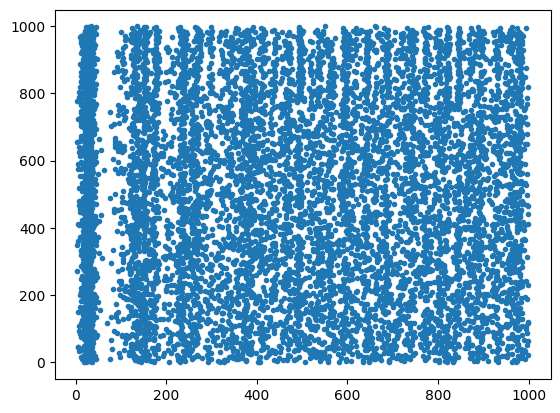

In [5]:
# Create network
net = PulseNetwork(1000)
net.config(dt=1.0)
net.compile()

# Single trial
def run(net, duration=1000):
    # Simulate
    net.simulate(duration)
    # Recordings
    t, n = net.M.raster_plot()
    return t, n

t, n = run(net, 1000)

plt.figure()
plt.plot(t, n, '.')
plt.show()

Using the `parallel_run` methods of `Network` allows to reinitialize the network and run the simulation multiple times in **parallel**, with different durations. The results of each simulation are concatenated and returned.

We make sure that the seeds of each network are different by setting the value `'sequential'`. `None` or a list of seeds would also work.

Note how, in the network definition, the rng of the random distributions was set using the seed of the network.

In [6]:
results = net.parallel_run(
    method=run, 
    number=8, 
    seeds='sequential', 
    duration=[200 * (i+1) for i in range(8)]
)

We can then plot the 8 simulations 

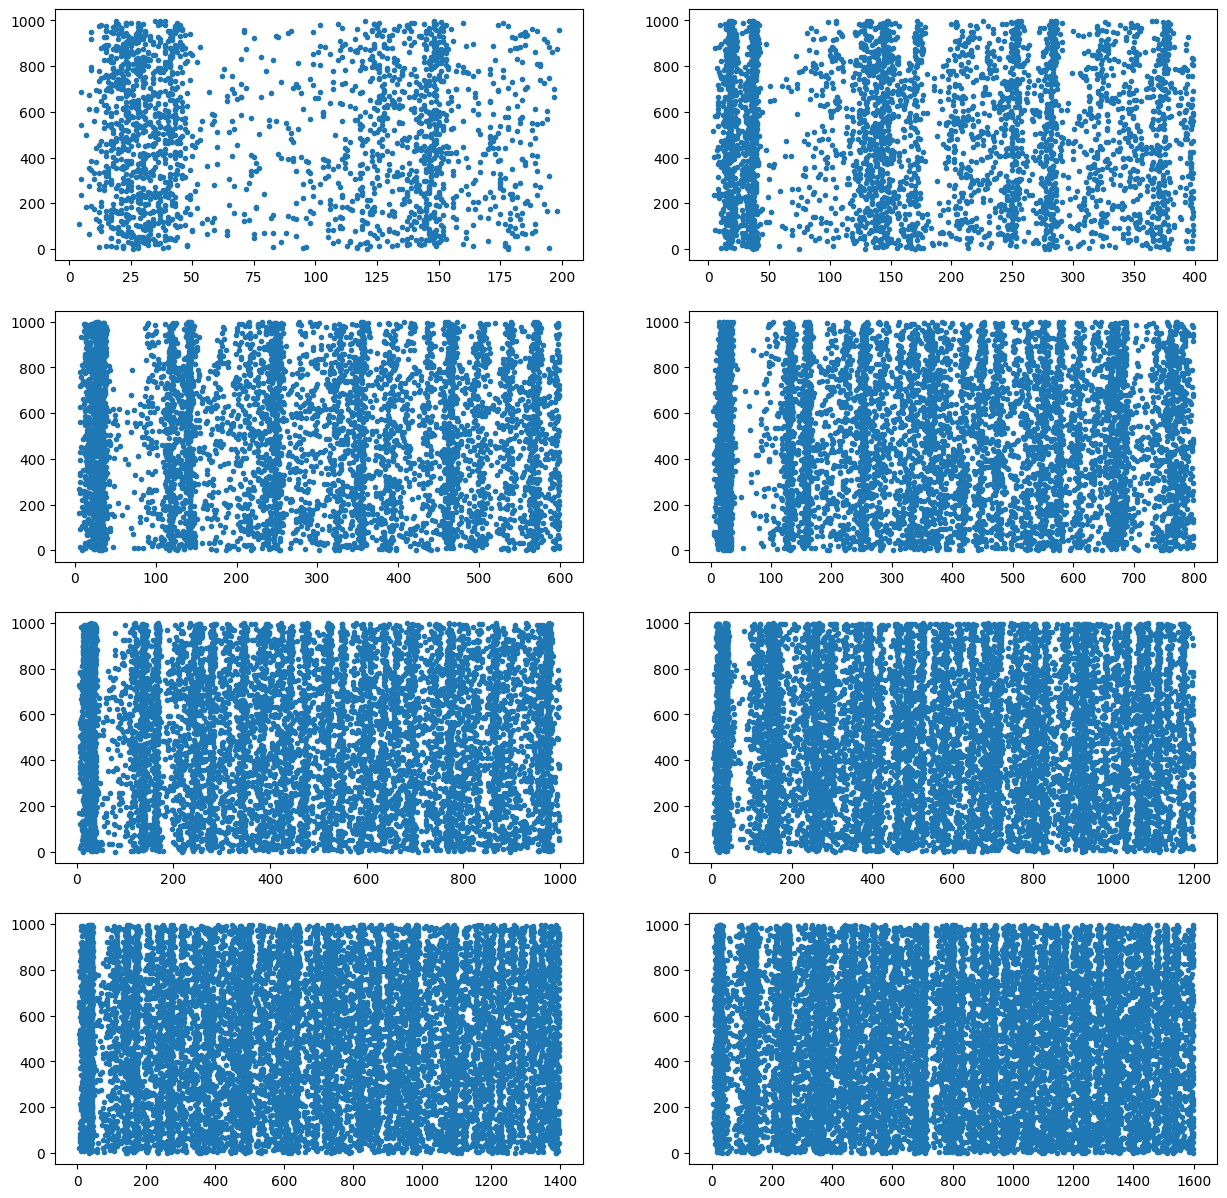

In [7]:
plt.figure(figsize=(15, 15))
for i in range(8):
    t, n = results[i]
    plt.subplot(4, 2, i+1)
    plt.plot(t, n, '.')
plt.show()

As a side note, it is important to define the network as a subclass of `ann.Network`, not just as an instance of `ann.Network()` where populations are created manually. `parallel_run()` needs to create copies of the network instance, which is only possible if the constructor of the class has all the required information to build those instances.

The following code should crash:

In [8]:
net = ann.Network()

pop = net.create(geometry=1000, neuron=ann.Izhikevich)
Exc = pop[:800]
Inh = pop[800:]

re = np.random.random(800)      ; ri = np.random.random(200)
Exc.noise = 5.0                 ; Inh.noise = 2.0
Exc.a = 0.02                    ; Inh.a = 0.02 + 0.08 * ri
Exc.b = 0.2                     ; Inh.b = 0.25 - 0.05 * ri
Exc.c = -65.0 + 15.0 * re**2    ; Inh.c = -65.0
Exc.d = 8.0 - 6.0 * re**2       ; Inh.d = 2.0
Exc.v = -65.0                   ; Inh.v = -65.0
Exc.u = Exc.v * Exc.b           ; Inh.u = Inh.v * Inh.b

exc_proj = net.connect(pre=Exc, post=pop, target='exc')
exc_proj.connect_all_to_all(weights=ann.Uniform(0.0, 0.5))
   
inh_proj = net.connect(pre=Inh, post=pop, target='inh')
inh_proj.connect_all_to_all(weights=ann.Uniform(0.0, 1.0))

m = net.monitor(pop, 'spike')

net.compile()

net.parallel_run(number=2, method=run)

Compiling network 2...  OK 


ANNarchyException: Network.parallel_run(): the network must be an instance of a class deriving from Network, not Network itself. 